In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import gpmultipy
import scipy
import pandas as pd

In [162]:
x = np.linspace(-1,1)[:,None]

yKernel = gpmultipy.kernel.White(1,1)
k = gpmultipy.kernel.RBF(1,.1,.5)

p = 10
beta = np.zeros((50,1))
beta[:,0] = scipy.stats.multivariate_normal.rvs(np.zeros(50),k.K(x))

dm = np.ones((1,p))
# dm[0,1.*p/2:] = -1

y = np.dot(beta,dm) + scipy.stats.multivariate_normal.rvs(np.zeros(50),yKernel.K(x),size=p).reshape((50,p))

model = gpmultipy.model.Model(x,y,dm)

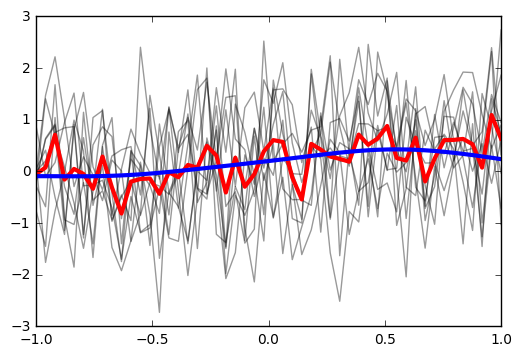

In [163]:
plt.plot(x,y,c='k',alpha=.4);
plt.plot(x,y.mean(1),c='r',lw=3)
plt.plot(x,beta,c='b',lw=3)

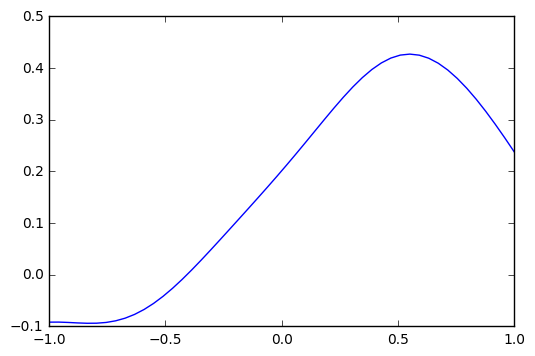

In [164]:
plt.plot(x,beta)

In [165]:
prior = gpmultipy.prior.VariableSelection(x,k,[0],theta=.1)
prior.sample(model,yKernel)

In [166]:
prior.inclusionLikelihood(model,yKernel,0), \
prior.marginalLikelihood(model,yKernel,0), prior.marginalLikelihood(model,yKernel,0,False)

(0.99800125075249468, -712.58688743510129, -720.99734493331505)

In [167]:
ySigmaPrior = gpmultipy.sampler.Slice('ysigma',
                                      lambda x: model.dataLikelihood(yKernel),
                                      #lambda x: scipy.stats.uniform(loc=1e-4,scale=1e1).logpdf(x),
                                      lambda x: scipy.stats.lognorm(s=1e-0,scale=1e0).logpdf(x),
                                      .2,5,logspace=True)

In [168]:
ySigmaPrior.loglikelihood(1), ySigmaPrior.prior_logdensity_fxn(1), ySigmaPrior.logdensity_fxn(1)

(-707.04782562967682, -0.91893853320467267, -701.17535294823892)

In [169]:
freeze = gpmultipy.Freezer(model=model,prior=prior,yKernel=yKernel)

In [216]:
nsample = 2000
samples = []
pis = []
for i in range(nsample):
    
    pi = prior.inclusionLikelihood(model,yKernel,0)
    pis.append(pi)
    
    prior.toggle[0] = scipy.stats.bernoulli(pi).rvs()
    
    if prior.toggle[0]:
        prior.sample(model,yKernel,)
    else:
        model.beta[:,0] = 0
        
    yKernel.sigma = ySigmaPrior.sample(yKernel.sigma)
        
    if i % 10 == 0:
        samples.append(freeze.freeze())

In [228]:
betaSamples = gpmultipy.ArraySamples(0,[s for s in samples if s['prior']['toggle'][0]],'model','beta')
betaInterval = gpmultipy.interval.FunctionInterval(betaSamples,.999)

toggle = gpmultipy.samples.LambdaSamples(lambda x: x[0],samples,'prior','toggle')
ysigma = gpmultipy.samples.Samples(samples,'yKernel','sigma')

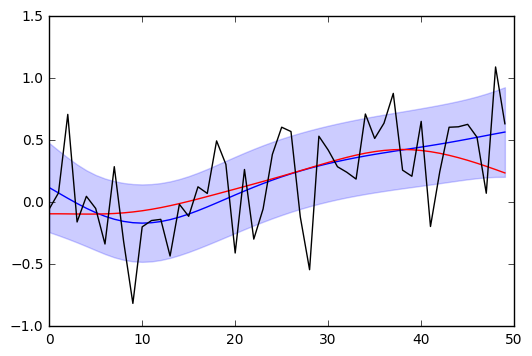

In [239]:
betaInterval.plot()
plt.plot(beta,c='r')
plt.plot(y.mean(1),c='k',alpha=1)

In [240]:
betaInterval.contains(beta[:,0])

True

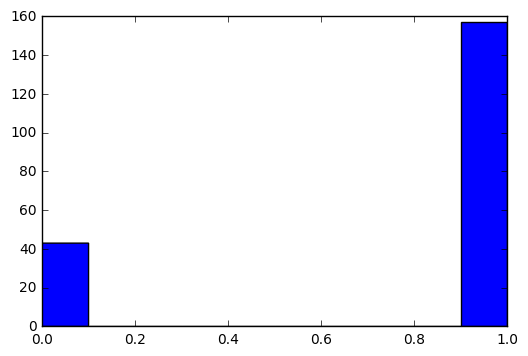

In [230]:
plt.hist([s['prior']['toggle'][0] for s in samples]);

In [231]:
sum([s['prior']['toggle'][0] for s in samples])*1./len(samples)

0.78500000000000003

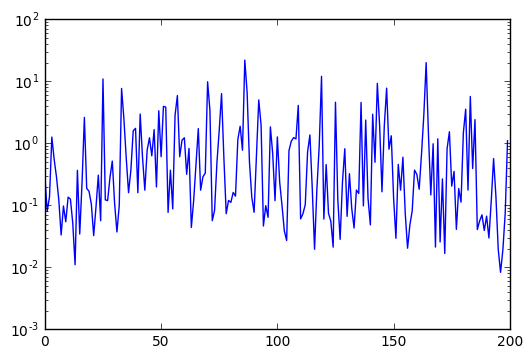

In [232]:
# plt.plot([s['yKernel']['sigma'] for s in samples]);
plt.plot(ysigma.samples);
plt.semilogy();

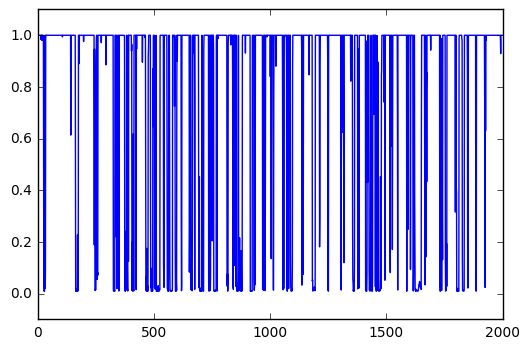

In [233]:
plt.plot(pis)
plt.ylim(-.1,1.1);

(-0.1, 1.1)

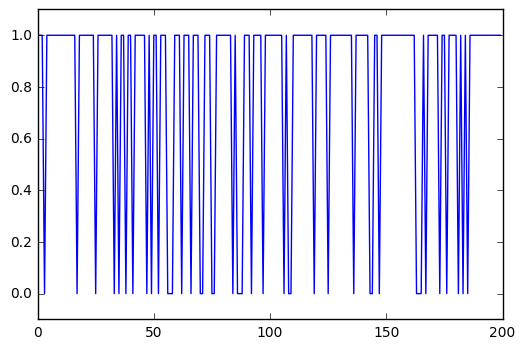

In [234]:
plt.plot(toggle.samples)
plt.ylim(-.1,1.1)

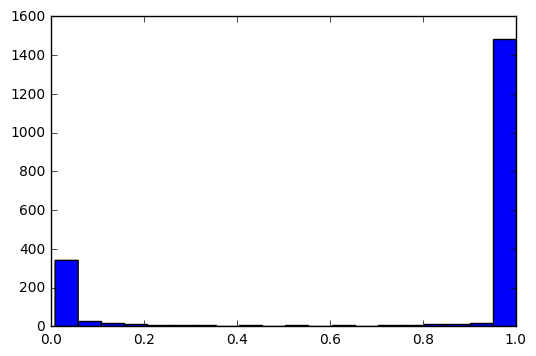

In [235]:
plt.hist(pis,20);

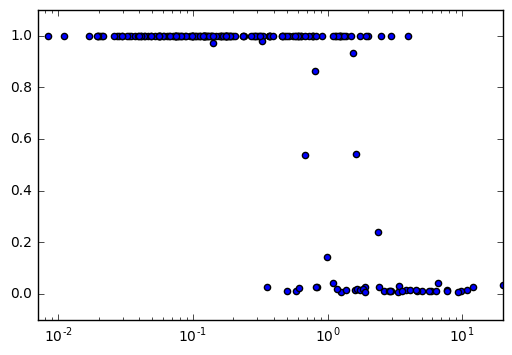

In [236]:
plt.scatter(ysigma.samples,pis[::10]);
plt.semilogx();
plt.xlim(7e-3,2e1)
plt.ylim(-.1,1.1);

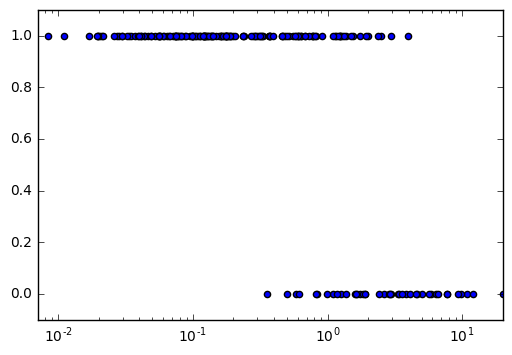

In [237]:
plt.scatter(ysigma.samples,toggle.samples);
plt.semilogx();
plt.xlim(7e-3,2e1)
plt.ylim(-.1,1.1);

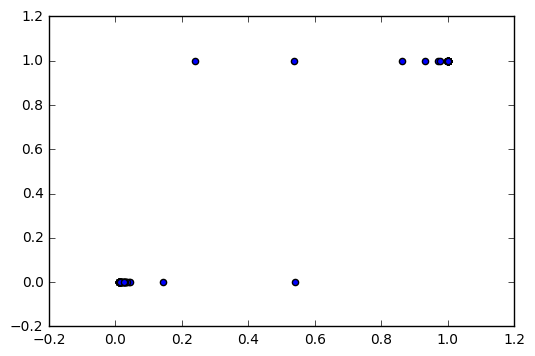

In [238]:
plt.scatter(pis[::10],toggle.samples)

In [143]:
x = np.linspace(-1,1)[:,None]
samplesizes = [5,10,15,20,25]

yKernel = gpmultipy.kernel.White(1,1)
k = gpmultipy.kernel.RBF(1,.05,.5)

beta = np.zeros((50,1))
beta[:,0] = scipy.stats.multivariate_normal.rvs(np.zeros(50),k.K(x))

dm = np.ones((1,max(samplesizes)))

y = np.dot(beta,dm) + scipy.stats.multivariate_normal.rvs(np.zeros(50),yKernel.K(x),size=max(samplesizes)).reshape((50,max(samplesizes)))

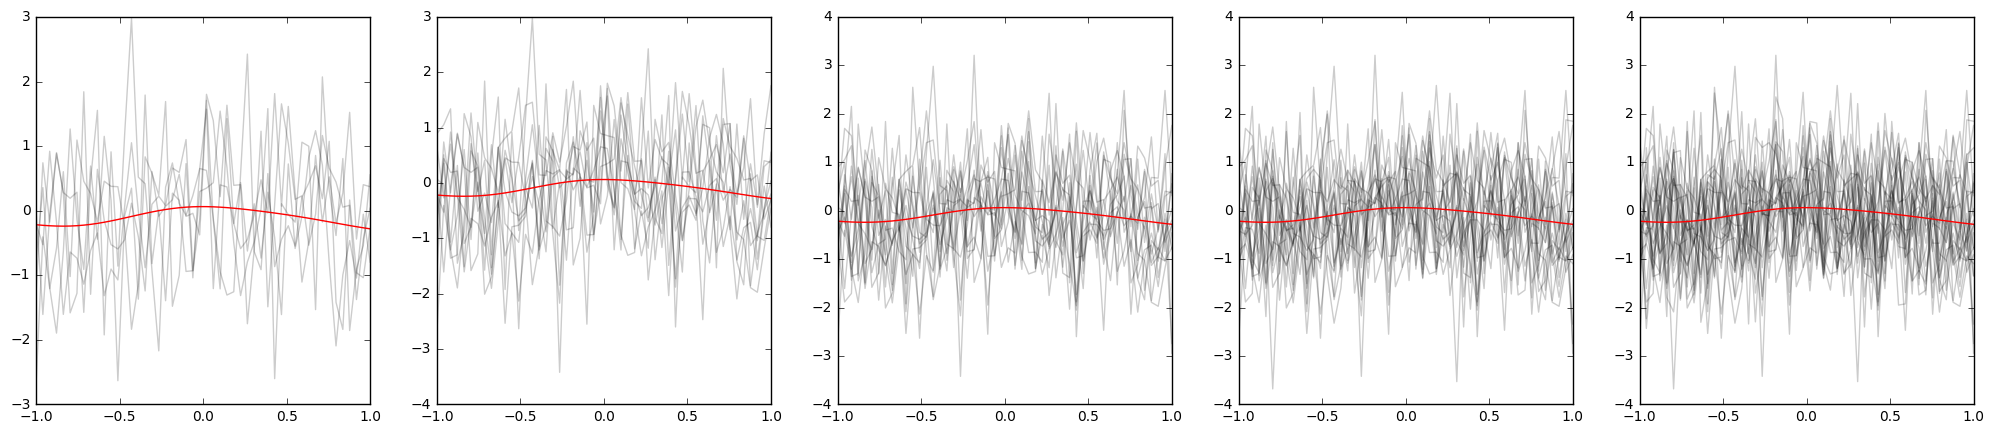

In [197]:
plt.figure(figsize=(5*len(samplesizes),5))
for i,p in enumerate(samplesizes):
    plt.subplot(1,len(samplesizes),i+1)
    plt.plot(x,y[:,:p],c='k',alpha=.2)
    plt.plot(x,beta,c='r')

In [198]:
allsamples = {}

for p in samplesizes:
    print p
    allsamples[p] = []

    dm = np.ones((1,p))

    model = gpmultipy.model.Model(x,y[:,:p],dm)
    prior = gpmultipy.prior.VariableSelection(x,k,[0],theta=.1)
    prior.sample(model,yKernel)
    
    ySigmaPrior = gpmultipy.sampler.Slice('ysigma',
                                      lambda x: model.dataLikelihood(yKernel),
                                      #lambda x: scipy.stats.uniform(loc=1e-4,scale=1e1).logpdf(x),
                                      lambda x: scipy.stats.lognorm(s=1e-0,scale=1e0).logpdf(x),
                                      .2,5,logspace=True)
    
    freeze = gpmultipy.Freezer(model=model,prior=prior,yKernel=yKernel)
    
    nsample = 500
    pis = []
    for i in range(nsample):

        pi = prior.inclusionLikelihood(model,yKernel,0)
        pis.append(pi)

        prior.toggle[0] = scipy.stats.bernoulli(pi).rvs()

        if prior.toggle[0]:
            prior.sample(model,yKernel,)
        else:
            model.beta[:,0] = 0

        yKernel.sigma = ySigmaPrior.sample(yKernel.sigma)

        if i % 10 == 0:
            allsamples[p].append(freeze.freeze())

5
10
15
20
25


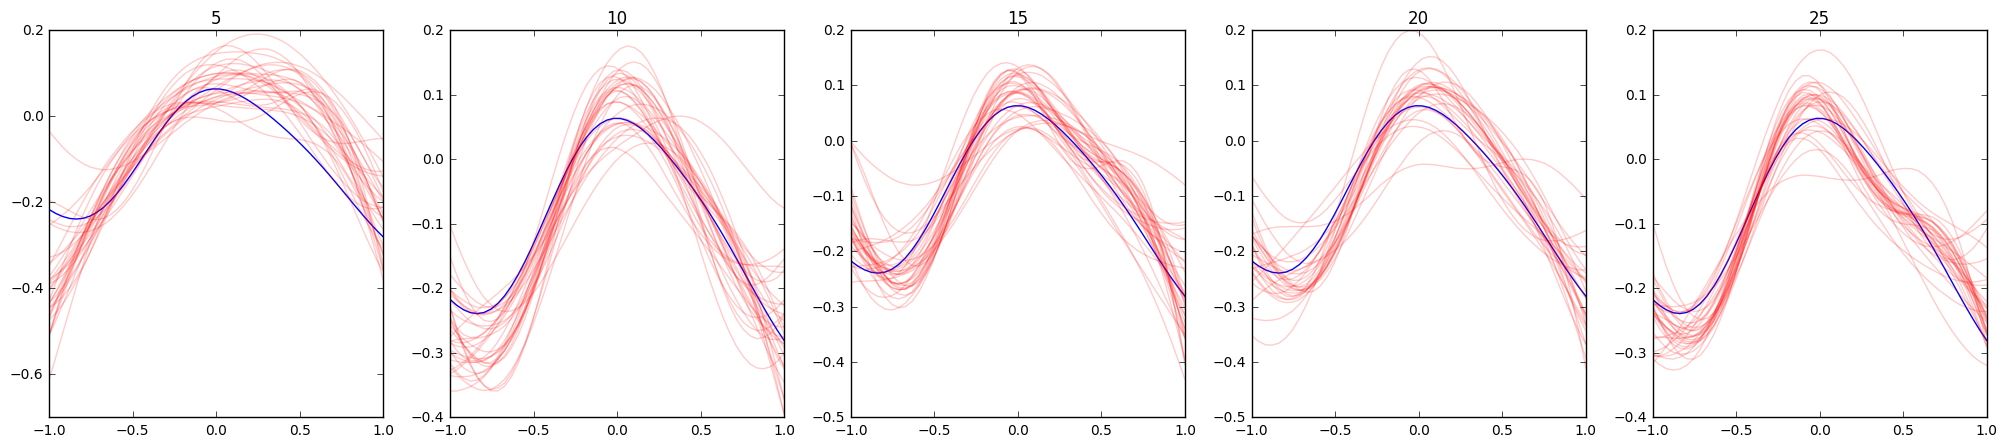

In [199]:
keys = allsamples.keys()
keys.sort()

plt.figure(figsize=(5*len(keys),5))

for i,k in enumerate(keys):
    plt.subplot(1,len(keys),i+1)
    plt.title(k)
    
    plt.plot(x,beta[:,0])
    [plt.plot(x,s['model']['beta'][:,0],c='r',alpha=.2) for s in allsamples[k] if s['prior']['toggle'][0]]

In [202]:
nrep = 5
allreps = {}
samplesizes = [5,10,15,20]
for j in range(nrep):
    print j
    
    x = np.linspace(-1,1)[:,None]

    yKernel = gpmultipy.kernel.White(1,1)
    k = gpmultipy.kernel.RBF(1,.05,.5)

    beta = np.zeros((50,1))
    beta[:,0] = scipy.stats.multivariate_normal.rvs(np.zeros(50),k.K(x))

    dm = np.ones((1,max(samplesizes)))

    y = np.dot(beta,dm) + scipy.stats.multivariate_normal.rvs(np.zeros(50),yKernel.K(x),size=max(samplesizes)).reshape((50,max(samplesizes)))
    
    allreps[j] = {}
    allreps[j]['data'] = y
    allreps[j]['beta'] = beta

    for p in samplesizes:
        print p
        allreps[j][p] = []

        dm = np.ones((1,p))

        model = gpmultipy.model.Model(x,y[:,:p],dm)
        prior = gpmultipy.prior.VariableSelection(x,k,[0],theta=.1)
        prior.sample(model,yKernel)

        ySigmaPrior = gpmultipy.sampler.Slice('ysigma',
                                          lambda x: model.dataLikelihood(yKernel),
                                          #lambda x: scipy.stats.uniform(loc=1e-4,scale=1e1).logpdf(x),
                                          lambda x: scipy.stats.lognorm(s=1e-0,scale=1e0).logpdf(x),
                                          .2,5,logspace=True)

        freeze = gpmultipy.Freezer(model=model,prior=prior,yKernel=yKernel)

        nsample = 500
        pis = []
        for i in range(nsample):

            pi = prior.inclusionLikelihood(model,yKernel,0)
            pis.append(pi)

            prior.toggle[0] = scipy.stats.bernoulli(pi).rvs()

            if prior.toggle[0]:
                prior.sample(model,yKernel,)
            else:
                model.beta[:,0] = 0

            yKernel.sigma = ySigmaPrior.sample(yKernel.sigma)

            if i % 10 == 0:
                allreps[j][p].append(freeze.freeze())


0
5
10
15
20
1
5
10
15
20
2
5
10
15
20
3
5
10
15
20
4
5
10
15
20


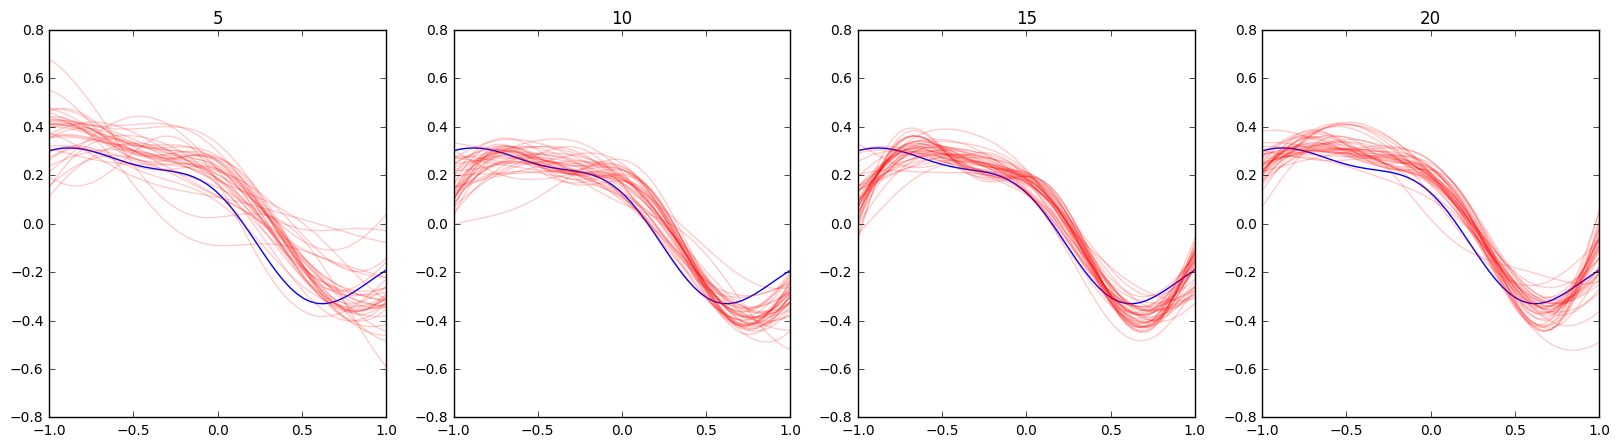

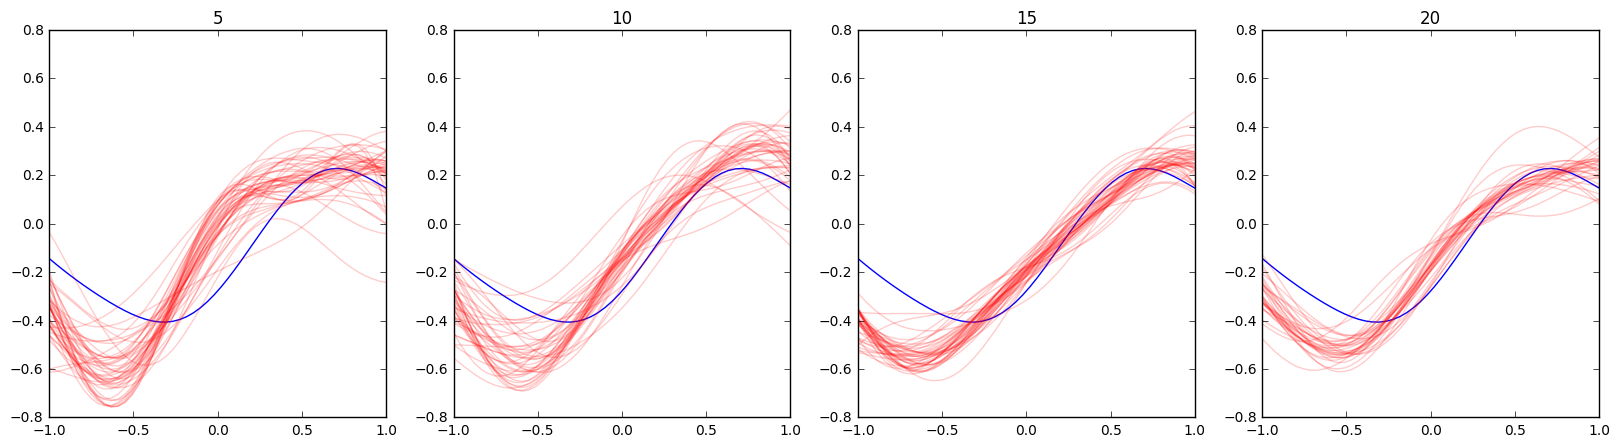

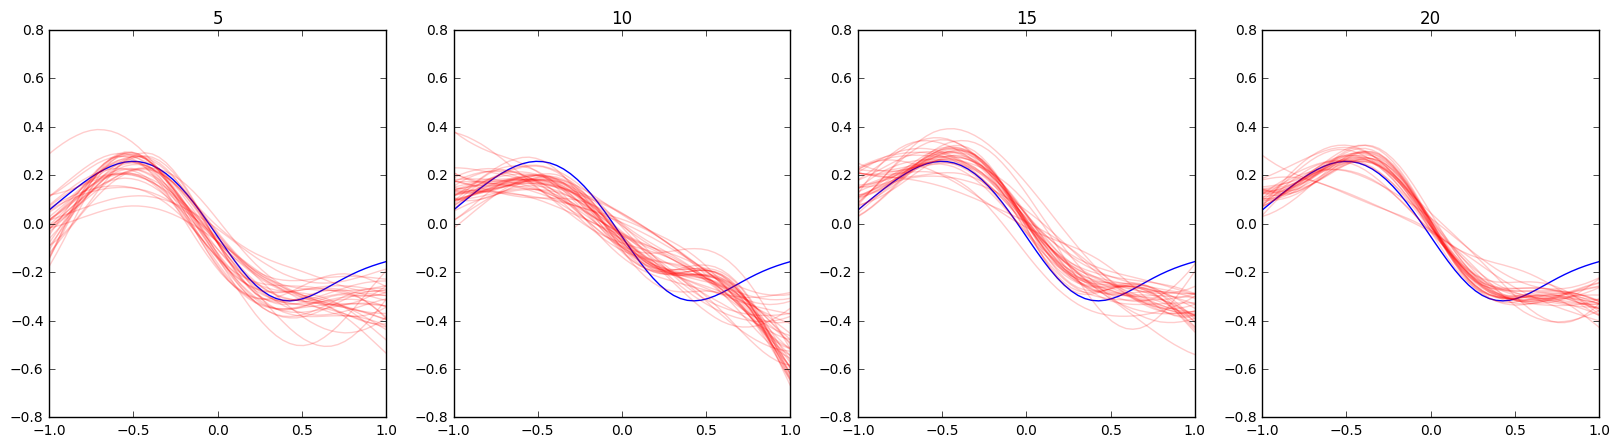

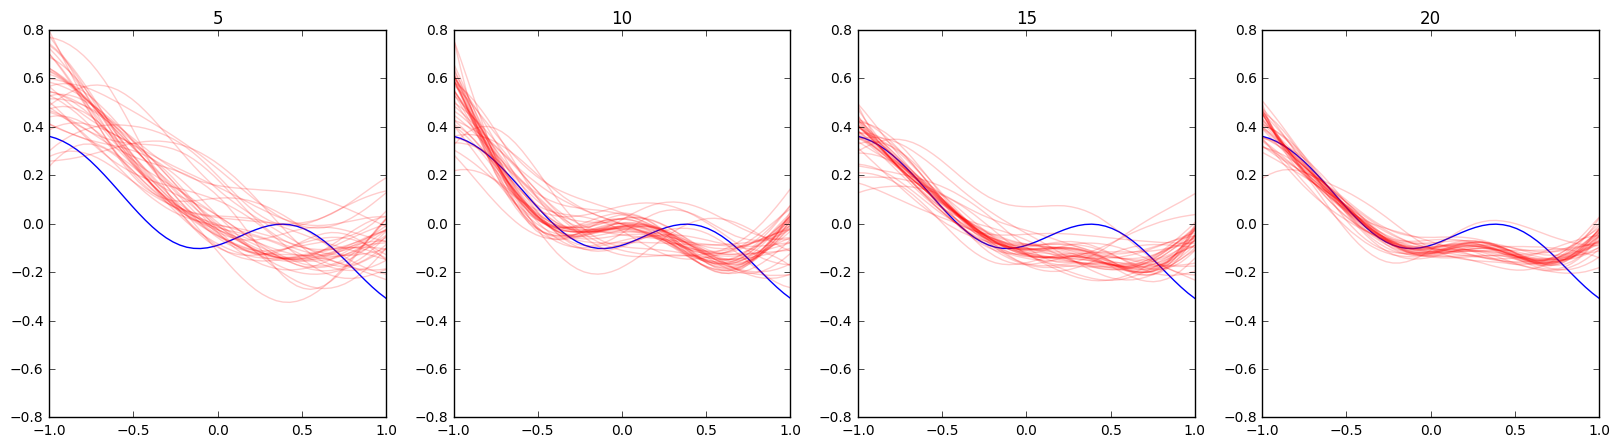

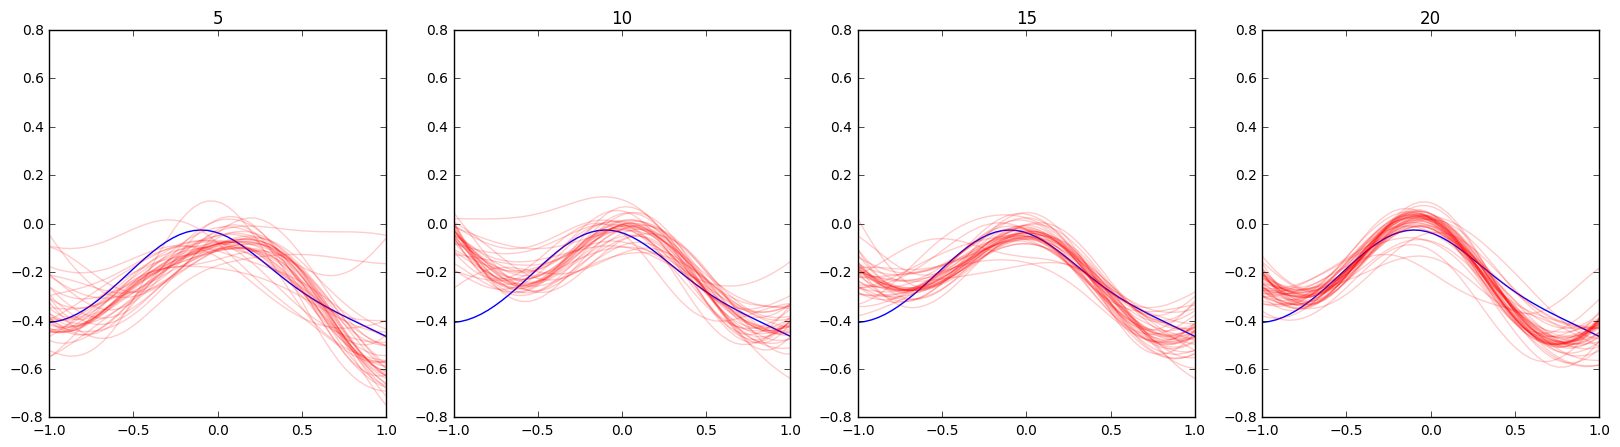

In [207]:
for i in allreps.keys():
    keys = allreps[i].keys()
    keys = filter(lambda x: x!='beta',keys)
    keys = filter(lambda x: x!='data',keys)
    keys.sort()

    plt.figure(figsize=(5*len(keys),5))

    for j,k in enumerate(keys):
        plt.subplot(1,len(keys),j+1)
        plt.title(k)

        plt.plot(x,allreps[i]['beta'][:,0])
        [plt.plot(x,s['model']['beta'][:,0],c='r',alpha=.2) for s in allreps[i][k] if s['prior']['toggle'][0]]
        plt.ylim(-.8,.8)

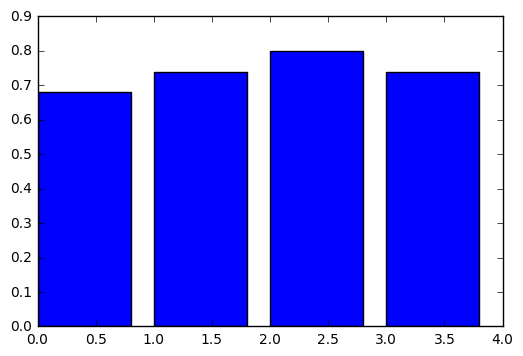

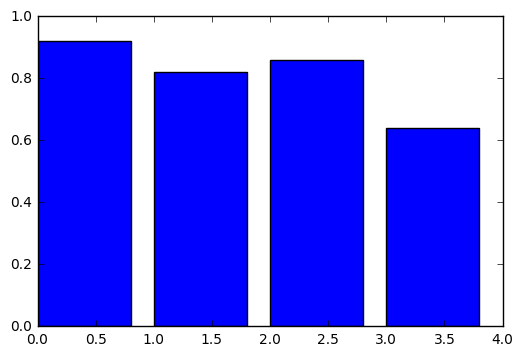

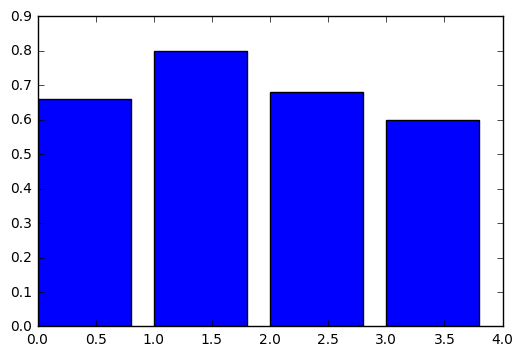

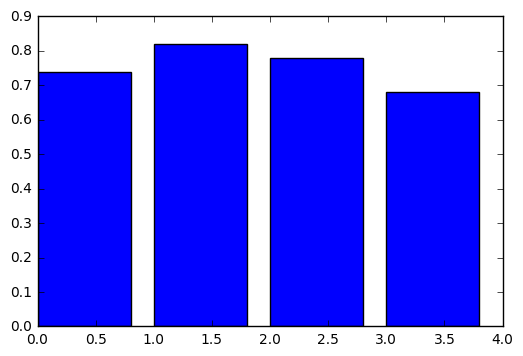

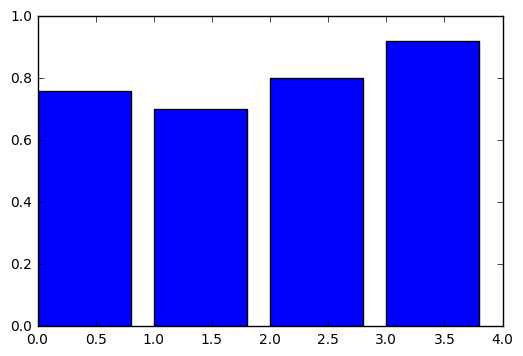

In [219]:
for i in allreps.keys():
    samples = allreps[i]
    keys = samples.keys()
    keys = filter(lambda x: x != 'beta',keys)
    keys = filter(lambda x: x != 'data',keys)
    keys.sort()
    
    toggle = [[s['prior']['toggle'][0] for s in samples[k]] for k in keys]
    ratio = [sum(t)*1./len(t) for t in toggle]
    
    plt.figure()
    plt.bar(range(len(keys)),ratio,)

In [43]:
x = np.linspace(-1,1)[:,None]
yKernel = gpmultipy.kernel.White(1,1)
theta = .01
p = 5

samples = {}

for s in np.power(10.,np.arange(-4,1,).tolist() + np.arange(-4-(1-np.log10(5)),1,).tolist()):
    samples[s] = []
    for rep in range(100):
        
        k = gpmultipy.kernel.RBF(1,s)

        beta = np.zeros((50,1))
        beta[:,0] = scipy.stats.multivariate_normal.rvs(np.zeros(50),k.K(x))

        dm = np.ones((1,p))

        y = np.dot(beta,dm) + scipy.stats.multivariate_normal.rvs(np.zeros(50),yKernel.K(x),size=p).reshape((50,p))

        model = gpmultipy.model.Model(x,y,dm)
        prior = gpmultipy.prior.VariableSelection(x,k,[0],theta=theta)
        
        samples[s].append(prior.inclusionLikelihood(model,yKernel,0))

In [44]:
samplesDf = pd.DataFrame(samples)

(-0.1, 1.1)

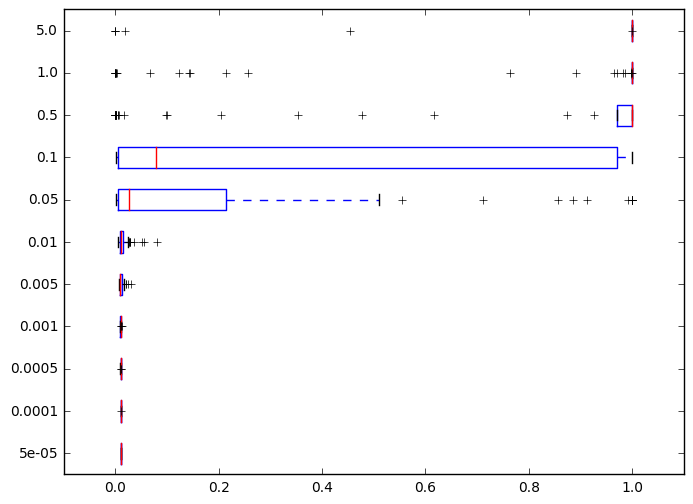

In [45]:
plt.figure(figsize=(8,6))
plt.boxplot(samplesDf.values,labels=samplesDf.columns,vert=False);
plt.xlim(-.1,1.1)